In [44]:
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.master('yarn').appName('TP-Final').getOrCreate()

df_spark = spark.read.json('hdfs://spark01:9000/datasets/dengue/amostra.json')

In [45]:
df_spark.count()

200000

In [46]:
df_spark.printSchema()

root
 |-- _id: long (nullable = true)
 |-- contributors: string (nullable = true)
 |-- control: struct (nullable = true)
 |    |-- classification: struct (nullable = true)
 |    |    |-- c: string (nullable = true)
 |    |    |-- d: long (nullable = true)
 |    |    |-- exp_dengue: struct (nullable = true)
 |    |    |    |-- campanha: double (nullable = true)
 |    |    |    |-- exp_pessoal: double (nullable = true)
 |    |    |    |-- informacao: double (nullable = true)
 |    |    |    |-- opiniao: double (nullable = true)
 |    |    |    |-- parodia: double (nullable = true)
 |    |    |    |-- result: array (nullable = true)
 |    |    |    |    |-- element: string (containsNull = true)
 |    |    |    |-- rules: long (nullable = true)
 |    |    |-- exp_dengue_bin: struct (nullable = true)
 |    |    |    |-- 0: double (nullable = true)
 |    |    |    |-- 1: double (nullable = true)
 |    |    |    |-- result: array (nullable = true)
 |    |    |    |    |-- element: boolean (co

In [47]:
import pyspark.sql.functions as F
df_spark = df_spark \
   .withColumn('Data', \
   F.to_date(F.to_timestamp(F.col("created_at.$date") / 1000))) \
  .withColumn('TEXT', \
  F.upper(F.col('text')))

In [48]:
df_spark.filter(df_spark.Data.isNotNull()).select('Data').count()

200000

In [49]:
df_spark.filter(df_spark.Data == '2018-09-16').select('Data').count()

714

In [50]:
# df_spark.groupby('Data').agg(F.countDistinct('Data')).sort('Data').show()
df_group1 = df_spark.groupby('Data').agg(F.count('Data')).sort('Data')
df_group1.show(n=190)

+----------+-----------+
|      Data|count(Data)|
+----------+-----------+
|2018-09-16|        714|
|2018-09-17|        585|
|2018-09-18|        637|
|2018-09-19|        571|
|2018-09-20|        483|
|2018-09-21|        703|
|2018-09-22|        608|
|2018-09-23|        539|
|2018-09-24|        727|
|2018-09-25|        540|
|2018-09-26|       1333|
|2018-09-27|        682|
|2018-09-28|        446|
|2018-09-29|        357|
|2018-09-30|        561|
|2018-10-01|        530|
|2018-10-02|        509|
|2018-10-03|        555|
|2018-10-04|        543|
|2018-10-05|        763|
|2018-10-06|        694|
|2018-10-07|        852|
|2018-10-08|        471|
|2018-10-09|        556|
|2018-10-10|        716|
|2018-10-11|        591|
|2018-10-12|        384|
|2018-10-13|        320|
|2018-10-14|       1839|
|2018-10-15|       1049|
|2018-10-16|        623|
|2018-10-17|        955|
|2018-10-18|        706|
|2018-10-19|        506|
|2018-10-20|        577|
|2018-10-21|        484|
|2018-10-22|        569|


In [51]:
df_group1.agg({'Data': 'min'}).show()

[Stage 36:=================================================>    (170 + 1) / 185]

+----------+
| min(Data)|
+----------+
|2018-09-16|
+----------+



In [52]:
df_group1.agg({'Data': 'max'}).show()

[Stage 42:===================================================>  (175 + 1) / 185]

+----------+
| max(Data)|
+----------+
|2019-03-19|
+----------+



In [37]:
# hashtags_pd.to_csv('/home/igorfranco/hashtags_pd.csv', index=False)

## 1. Palavras
O uso de hashtags (#) no Twitter permite que os seguidores coloquem discussões em
torno de tópicos específicos, incluindo temas ou eventos de saúde pública. Portanto, no
período informado, é possível identificar qual das três doenças (Dengue, zika e
chikungunya) teve maior incidência nos comentários?

In [53]:
df_spark = df_spark.withColumn('Doenca', F.when(df_spark.TEXT.like('%CHI%UNGUN%A%'), 'CHIKUNGUNYA') \
                                 .when(df_spark.TEXT.like('%ZI%A%'), 'ZIKA') \
                                 .when(df_spark.TEXT.like('%DENGUE%'), 'DENGUE')
                                 .otherwise('NULL')) 
#                                  .select('TEXT','Doenca','Data')

In [54]:
df_spark.groupby('Doenca').agg(F.count('Doenca').alias('Count_Doenca')).sort('Count_Doenca', ascending=False).show()

[Stage 45:=======================================>              (147 + 2) / 200]

+-----------+------------+
|     Doenca|Count_Doenca|
+-----------+------------+
|     DENGUE|       89659|
|       ZIKA|       65729|
|       NULL|       35885|
|CHIKUNGUNYA|        8727|
+-----------+------------+



In [55]:
palavras_count1 = df_spark.groupby('Doenca').agg(F.count('Doenca').alias('Count_Doenca')).sort('Count_Doenca', ascending=False)

In [56]:
doenca = palavras_count1.filter(palavras_count1.Doenca.like('%DENGUE%') | palavras_count1.Doenca.like('%ZI%A%') | palavras_count1.Doenca.like('%CHI%UNGUN%A%')).toPandas()

In [57]:
doenca3 = doenca.head(3)

In [58]:
print(doenca3)

        Doenca  Count_Doenca
0       DENGUE         89659
1         ZIKA         65729
2  CHIKUNGUNYA          8727


<AxesSubplot:title={'center':'Contagem de Doenças por palavras em Tweets'}, ylabel='Count_Doenca'>

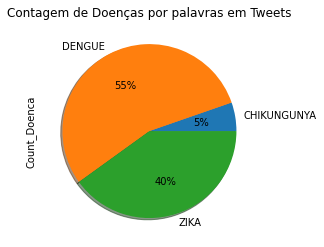

In [59]:
doenca3.groupby(['Doenca']).sum().plot(kind='pie', y='Count_Doenca', shadow=True, legend = False, autopct='%1.0f%%', title='Contagem de Doenças por palavras em Tweets')

## 2. Quantidade de tweets por doença (hashtags) no decorrer dos dias. 
Através dessa informação é possível sugerir se houve surtos de alguma doença no período.

In [107]:
import pandas as pd

In [6]:
# Linhas de tweets com "dengue"
dengue = df_spark.filter(df_spark.Doenca.like('%DENGUE%'))\
          .select('Data','TEXT')

In [7]:
# Linhas de tweets com "zika"
zika = df_spark.filter(df_spark.Doenca.like('%ZI%A%'))\
          .select('Data','TEXT')

In [8]:
# Linhas de tweets com "chikungunya"
chikungunya = df_spark.filter(df_spark.Doenca.like('%CHI%UNGUN%A%'))\
          .select('Data','TEXT')

In [9]:
dengue_group = dengue.groupby('Data').agg(F.count('Data').alias('Count_dengue')).sort('Data').toPandas()

In [10]:
dengue_group

,Data,Count_dengue
0,2018-09-16,74
1,2018-09-17,154
2,2018-09-18,214
3,2018-09-19,193
4,2018-09-20,188
...,...,...
179,2019-03-15,1016
180,2019-03-16,1048
181,2019-03-17,611
182,2019-03-18,753


In [37]:
dengue_group.loc[dengue_group['Count_dengue'][::-1].idxmax()]

Data            2019-03-13
Count_dengue          8564
Name: 177, dtype: object

In [43]:
dengue_group.sort_values(by='Count_dengue', ascending=False). head(15)

,Data,Count_dengue
177,2019-03-13,8564
159,2019-02-23,4670
160,2019-02-24,3253
171,2019-03-07,2974
170,2019-03-06,2477
176,2019-03-12,1760
178,2019-03-14,1617
172,2019-03-08,1487
164,2019-02-28,1302
161,2019-02-25,1084


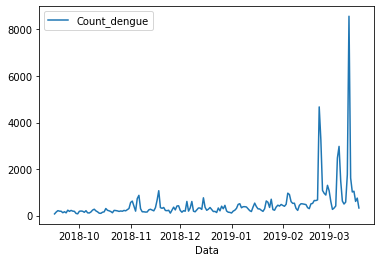

In [18]:
ax = dengue_group.plot.line(x='Data')

In [19]:
zika_group = zika.groupby('Data').agg(F.count('Data').alias('Count_zika')).sort('Data').toPandas()

In [36]:
zika_group.loc[zika_group['Count_zika'][::-1].idxmax()]

Data          2019-01-23
Count_zika          6149
Name: 128, dtype: object

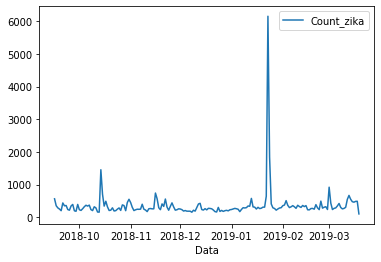

In [21]:
ax = zika_group.plot.line(x='Data')

In [38]:
chikungunya_group = chikungunya.groupby('Data').agg(F.count('Data').alias('Count_chikungunya')).sort('Data').toPandas()

In [39]:
chikungunya_group.loc[chikungunya_group['Count_chikungunya'][::-1].idxmax()]

Data                 2019-01-31
Count_chikungunya           534
Name: 136, dtype: object

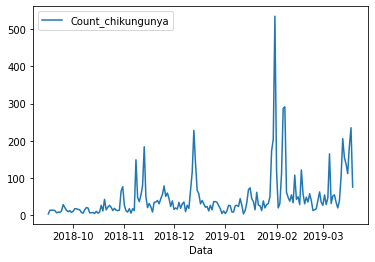

In [40]:
ax = chikungunya_group.plot.line(x='Data')

In [120]:
consolidado = pd.merge(dengue_group,zika_group, how='outer', on=['Data','Data'])

In [121]:
consolidado = pd.merge(consolidado,chikungunya_group, how='outer', on=['Data','Data'])

In [122]:
consolidado.fillna(0, inplace = True)

In [123]:
consolidado.dtypes

Data                 object
Count_dengue          int64
Count_zika            int64
Count_chikungunya     int64
dtype: object

In [124]:
print(consolidado)

           Data  Count_dengue  Count_zika  Count_chikungunya
0    2018-09-16            74         567                  4
1    2018-09-17           154         355                 14
2    2018-09-18           214         289                 14
3    2018-09-19           193         253                 14
4    2018-09-20           188         203                 13
..          ...           ...         ...                ...
179  2019-03-15          1016         479                138
180  2019-03-16          1048         464                112
181  2019-03-17           611         488                185
182  2019-03-18           753         492                235
183  2019-03-19           328         105                 76

[184 rows x 4 columns]


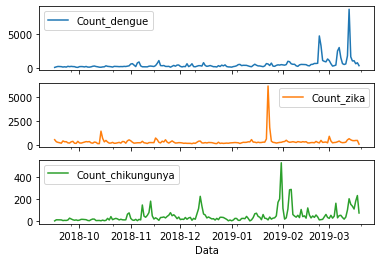

In [125]:
ax = consolidado.plot.line(x='Data', subplots=True)

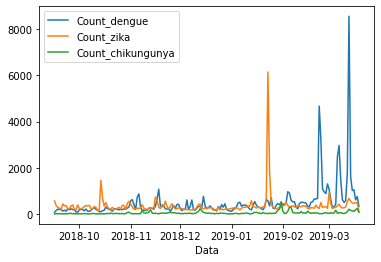

In [126]:
ax = consolidado.plot.line(x='Data')

## 3. Determinados cidades podem ter maior incidência de uma determinada doença. 
É possível identificar as cidades com maior incidência de cada tipo de doença e mostrar as 5
principais?

In [127]:
# Relacao da quantidade total de tweets por cidade
df_spark.select(F.col('control.geo.city').alias('Cidade')) \
        .groupby('Cidade').agg(F.count('Cidade').alias('Count')) \
        .sort('Count', ascending=False) \
        .show(n=15)

[Stage 124:=======================================>             (150 + 2) / 200]

+--------------+-----+
|        Cidade|Count|
+--------------+-----+
|            BH| 3385|
|      Brasilia| 3024|
|      Curitiba| 2693|
|Rio de Janeiro| 2683|
|  Campo Grande| 1993|
|            SP| 1943|
|    Uberlandia| 1850|
|  Porto Alegre| 1820|
|       Goiania| 1656|
|        Recife| 1261|
|        Manaus| 1104|
|      Campinas| 1099|
|      Blumenau| 1066|
|     Fortaleza|  982|
|      Salvador|  965|
+--------------+-----+
only showing top 15 rows



### Linhas de tweets com "dengue"

In [130]:
dengue_group_city = df_spark.filter(df_spark.Doenca.like('%DENGUE%') & df_spark.control.geo.city.isNotNull())\
          .select(F.col('control.geo.city').alias('Cidade'),'TEXT')

In [131]:
dengue_group_city.show(n=5)

+------------------+--------------------+
|            Cidade|                TEXT|
+------------------+--------------------+
|            Franca|NAGAZAP MAIS PARA...|
|         Porangatu|@BIANKAMARQUESS N...|
|         Cabo Frio|AGORA QUALQUER EN...|
|        Petropolis|A MINHA PRIMA DA ...|
|Laranjeiras do Sul|GUARANIAÇU:ALUNOS...|
+------------------+--------------------+
only showing top 5 rows



In [132]:
dengue_group_city.count()

36977

In [133]:
dengue_group_city = dengue_group_city.groupby('Cidade').agg(F.count('Cidade').alias('Count_Dengue_city')).sort('Count_Dengue_city', ascending=False).toPandas()

In [134]:
dengue_group_city.head(5)

,Cidade,Count_Dengue_city
0,BH,1795
1,Rio de Janeiro,1454
2,Brasilia,1450
3,Campo Grande,1004
4,Goiania,940


### Linhas de tweets com "zika"

In [135]:
zika_group_city = df_spark.filter(df_spark.Doenca.like('%ZIKA%') & df_spark.control.geo.city.isNotNull())\
          .select(F.col('control.geo.city').alias('Cidade'),'TEXT')

In [136]:
zika_group_city.show(n=5)

+---------------+--------------------+
|         Cidade|                TEXT|
+---------------+--------------------+
|Duque de Caxias|RT @ASORYLE: INTU...|
|       Alenquer|RT @ASORYLE: INTU...|
|  Florianopolis|EM PERNAMBUCO, CA...|
|        Tijucas|EM PERNAMBUCO, CA...|
|        Diadema|RT @ASORYLE: INTU...|
+---------------+--------------------+
only showing top 5 rows



In [137]:
zika_group_city.count()

30334

In [138]:
zika_group_city = zika_group_city.groupby('Cidade').agg(F.count('Cidade').alias('Count_Zika_city')).sort('Count_Zika_city', ascending=False).toPandas()

In [139]:
zika_group_city.head(5)

,Cidade,Count_Zika_city
0,Curitiba,1297
1,BH,882
2,Uberlandia,860
3,SP,836
4,Brasilia,819


### Linhas de tweets com "chikungunya"

In [140]:
chikungunya_group_city = df_spark.filter(df_spark.Doenca.like('%CHIKUNGUNYA%') & df_spark.control.geo.city.isNotNull())\
          .select(F.col('control.geo.city').alias('Cidade'),'TEXT')

In [141]:
chikungunya_group_city.show(n=5)

+------------+--------------------+
|      Cidade|                TEXT|
+------------+--------------------+
|    Santarem|E MAIS UMA VEZ O ...|
|     Artigas|TU ERES COMO ESA ...|
|       Serio|HOJE VOU DORMIR C...|
|    Salvador|GOSTEI DE UM VÍDE...|
|Manoel Viana|FÓRUM ABORDA DENG...|
+------------+--------------------+
only showing top 5 rows



In [142]:
chikungunya_group_city.count()

3386

In [143]:
chikungunya_group_city = chikungunya_group_city.groupby('Cidade').agg(F.count('Cidade').alias('Count_Chikungunya_city')).sort('Count_Chikungunya_city', ascending=False).toPandas()

In [144]:
chikungunya_group_city.head(5)

,Cidade,Count_Chikungunya_city
0,Brasilia,149
1,Andresito,141
2,Rio de Janeiro,127
3,BH,126
4,Fortaleza,106


In [145]:
# A titulo de verificacao se a baixa quantidade de cidade gerada acima tem a ver com os campos nulos
# Gerei novamente os resultados
df_spark.filter(df_spark.TEXT.like('%CHI%UNGUN%A%')) \
          .select(F.col('control.geo.city').alias('Cidade'),'TEXT') \
          .groupby('Cidade') \
          .agg(F.count('Cidade').alias('Count')) \
          .sort('Count', ascending=False).show()

[Stage 151:===================================>                 (135 + 2) / 200]

+---------------+-----+
|         Cidade|Count|
+---------------+-----+
|       Brasilia|  149|
|      Andresito|  141|
| Rio de Janeiro|  127|
|             BH|  126|
|      Fortaleza|  106|
|             SP|   97|
|        Artigas|   82|
|         Recife|   72|
|         Manaus|   64|
|          Belem|   63|
|       Salvador|   59|
|       Curitiba|   56|
|   Porto Alegre|   53|
|  Florianopolis|   53|
|        Goiania|   53|
|    Joao Pessoa|   52|
|   Campo Grande|   50|
|Duque de Caxias|   43|
|       Teresina|   42|
|         Palmas|   42|
+---------------+-----+
only showing top 20 rows



## 4. Criar um classificador para identificar os assuntos (dengue, zika ou chikungunya)
com base no tweet (desconsiderando as #) ? Determinar a qualidade do modelo

In [146]:
df_spark.groupby('Doenca').agg(F.count('Doenca').alias('Count_Doenca')).sort('Count_Doenca', ascending=False).show()

[Stage 153:==========================================>          (160 + 2) / 200]

+-----------+------------+
|     Doenca|Count_Doenca|
+-----------+------------+
|     DENGUE|       89659|
|       ZIKA|       65729|
|       NULL|       35885|
|CHIKUNGUNYA|        8727|
+-----------+------------+



In [147]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [148]:
cv = CountVectorizer(inputCol="text_sem_doenca", outputCol="features", vocabSize=100, minDF=2.0)

In [165]:
# Capturar apenas colunas a serem utilizadas
df_texto = df_spark.withColumn('text', F.lower(F.regexp_replace('TEXT', '#',''))).withColumn("text_vec", F.split('text', ' '))\
        .select('text', 'text_vec', 'Doenca')

In [166]:
df_texto.show()

+--------------------+--------------------+-----------+
|                text|            text_vec|     Doenca|
+--------------------+--------------------+-----------+
|vota no alckmin s...|[vota, no, alckmi...|       NULL|
|rt @spfcdadecepca...|[rt, @spfcdadecep...|       ZIKA|
|rt @asoryle: intu...|[rt, @asoryle:, i...|       ZIKA|
|rt @asoryle: intu...|[rt, @asoryle:, i...|       ZIKA|
|em pernambuco, ca...|[em, pernambuco,,...|       ZIKA|
|em pernambuco, ca...|[em, pernambuco,,...|       ZIKA|
|mano queria ta co...|[mano, queria, ta...|CHIKUNGUNYA|
|rt @asoryle: intu...|[rt, @asoryle:, i...|       ZIKA|
|- cemitérios da z...|[-, cemitérios, d...|CHIKUNGUNYA|
|@welintosilva217 ...|[@welintosilva217...|     DENGUE|
|em pernambuco, ca...|[em, pernambuco,,...|       ZIKA|
|@praknowles @meum...|[@praknowles, @me...|     DENGUE|
|rt @fllwwws: já p...|[rt, @fllwwws:, j...|       NULL|
|rt @spfcdadecepca...|[rt, @spfcdadecep...|       ZIKA|
|arapongas registr...|[arapongas, regis...|     

In [167]:
df_texto = df_texto\
                .withColumn("text_sem_doenca", F.expr("filter(text_vec, x -> x not in ('dengue','zika','zica','chicungunya','chikungunya','chicungunha','chikungunha'))"))

In [168]:
df_texto.show()

+--------------------+--------------------+-----------+--------------------+
|                text|            text_vec|     Doenca|     text_sem_doenca|
+--------------------+--------------------+-----------+--------------------+
|vota no alckmin s...|[vota, no, alckmi...|       NULL|[vota, no, alckmi...|
|rt @spfcdadecepca...|[rt, @spfcdadecep...|       ZIKA|[rt, @spfcdadecep...|
|rt @asoryle: intu...|[rt, @asoryle:, i...|       ZIKA|[rt, @asoryle:, i...|
|rt @asoryle: intu...|[rt, @asoryle:, i...|       ZIKA|[rt, @asoryle:, i...|
|em pernambuco, ca...|[em, pernambuco,,...|       ZIKA|[em, pernambuco,,...|
|em pernambuco, ca...|[em, pernambuco,,...|       ZIKA|[em, pernambuco,,...|
|mano queria ta co...|[mano, queria, ta...|CHIKUNGUNYA|[mano, queria, ta...|
|rt @asoryle: intu...|[rt, @asoryle:, i...|       ZIKA|[rt, @asoryle:, i...|
|- cemitérios da z...|[-, cemitérios, d...|CHIKUNGUNYA|[-, cemitérios, d...|
|@welintosilva217 ...|[@welintosilva217...|     DENGUE|[@welintosilva217...|

In [169]:
df_resumo = df_texto\
        .select('text', 'text_sem_doenca', 'Doenca')\
        .filter(F.col('Doenca') != 'NULL')

In [170]:
df_resumo.show()

+--------------------+--------------------+-----------+
|                text|     text_sem_doenca|     Doenca|
+--------------------+--------------------+-----------+
|rt @spfcdadecepca...|[rt, @spfcdadecep...|       ZIKA|
|rt @asoryle: intu...|[rt, @asoryle:, i...|       ZIKA|
|rt @asoryle: intu...|[rt, @asoryle:, i...|       ZIKA|
|em pernambuco, ca...|[em, pernambuco,,...|       ZIKA|
|em pernambuco, ca...|[em, pernambuco,,...|       ZIKA|
|mano queria ta co...|[mano, queria, ta...|CHIKUNGUNYA|
|rt @asoryle: intu...|[rt, @asoryle:, i...|       ZIKA|
|- cemitérios da z...|[-, cemitérios, d...|CHIKUNGUNYA|
|@welintosilva217 ...|[@welintosilva217...|     DENGUE|
|em pernambuco, ca...|[em, pernambuco,,...|       ZIKA|
|@praknowles @meum...|[@praknowles, @me...|     DENGUE|
|rt @spfcdadecepca...|[rt, @spfcdadecep...|       ZIKA|
|em pernambuco, ca...|[em, pernambuco,,...|       ZIKA|
|nagazap mais para...|[nagazap, mais, p...|     DENGUE|
|rt @aolivx_: naga...|[rt, @aolivx_:, n...|     

In [171]:
df_resumo.count()

164115

In [172]:
model = cv.fit(df_resumo)
result = model.transform(df_resumo)

#dividir em conjunto de treino e teste
(dado_treino, dado_teste) = result.randomSplit([0.7, 0.3])

In [173]:
labelIndexer = StringIndexer(inputCol="Doenca", outputCol="indexedLabel").fit(result)

In [174]:
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=100).fit(result)

In [175]:
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10, maxBins = 99)

In [176]:
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

In [177]:
# Chain indexers and forest in a Pipeline

pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

In [178]:
# Treinar o modelo
model = pipeline.fit(dado_treino)

In [179]:
# Predição
predictions = model.transform(dado_teste)

In [180]:
# Amostra dos dados 
predictions.select("predictedLabel", "Doenca", "features").show(15, False)

[Stage 185:>                                                        (0 + 1) / 1]

+--------------+------+------------------------------------------------------------+
|predictedLabel|Doenca|features                                                    |
+--------------+------+------------------------------------------------------------+
|DENGUE        |ZIKA  |(100,[3,6,10,12,15,63],[1.0,1.0,1.0,1.0,1.0,1.0])           |
|DENGUE        |ZIKA  |(100,[0,7,9,18,21,29,64],[2.0,1.0,1.0,1.0,1.0,1.0,1.0])     |
|DENGUE        |DENGUE|(100,[0,6,12],[1.0,1.0,1.0])                                |
|DENGUE        |DENGUE|(100,[0,2,9,12,23,70],[1.0,1.0,1.0,1.0,1.0,1.0])            |
|DENGUE        |DENGUE|(100,[9,26,89],[1.0,1.0,1.0])                               |
|DENGUE        |DENGUE|(100,[26],[1.0])                                            |
|DENGUE        |ZIKA  |(100,[0,61,70],[1.0,1.0,1.0])                               |
|DENGUE        |DENGUE|(100,[9,16,23],[1.0,1.0,1.0])                               |
|DENGUE        |DENGUE|(100,[40],[1.0])                          

In [181]:
# Computar o erro do modelo
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

In [182]:
accuracy = evaluator.evaluate(predictions)
print("Erro do teste = %g" % (1.0 - accuracy))

[Stage 188:==================================================>     (9 + 1) / 10]

Erro do teste = 0.343372
